# Denoising Transformer

**Reference:**

D. Chen, W. Hong and X. Zhou, "Transformer Network for Remaining Useful Life Prediction of Lithium-Ion Batteries," in IEEE Access, vol. 10, pp. 19621-19628, 2022.

**Based on their code hosted on Github:**

https://github.com/XiuzeZhou/RUL

## Preparing Datasets and Packages

In [1]:
!nvidia-smi

Tue Jan  3 10:22:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install needed packages
!pip install torchinfo
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 29.0 MB/s 
     |████████████████████████████████| 7.6 MB 40.6 MB/s 
     |████████████████████████████████| 182 kB 51.7 MB/s 


In [3]:
# import packages
import shutil
import os
from google.colab import drive
from tqdm.auto import tqdm
from pathlib import Path

# mount drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# If LOAD_NPY = True, npy file will be loaded instead of processing
# the xlsx files
LOAD_NPY = True

if LOAD_NPY:
  # define paths
  dest = '/content/'                                      # this is in the colab VM (local folder)
  drive_src = '/content/drive/MyDrive/datasets/CALCE/'    # location from GDrive (folder)
  src = drive_src + "CALCE.npy"                           # Specify file name
  print(f"Copying {src} to {dest}")                       
  shutil.copy(src,dest)                                   # Copy to dest
else:
  # Create folder
  Path("datasets/CALCE/").mkdir(parents=True, exist_ok=True)

  # define paths
  loc_dest = '/content/datasets/CALCE/'                    # this is in the colab VM (local folder)
  drive_src = '/content/drive/MyDrive/datasets/CALCE/'     # location from GDrive (folder)

  # copy to dest
  for foldername in tqdm(['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']):
    src = drive_src + foldername + '/'
    dest = loc_dest + foldername + '/' 

    shutil.copytree(src,dest)

Copying /content/drive/MyDrive/datasets/CALCE/CALCE.npy to /content/


## Import Packages

In [14]:
import numpy as np
import random
import math
import time
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pathlib
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Data Processing

In [7]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [8]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

if LOAD_NPY:
  Battery = np.load('CALCE.npy', allow_pickle=True)
  Battery = Battery.item()
  print(f"Loaded 'CALCE.npy'")
else:
  dir_path = 'datasets/CALCE/'
  Battery = {}
  for name in Battery_list:
      print('Load Dataset ' + name + ' ...')
      path = glob.glob(dir_path + name + '/*.xlsx')
      dates = []
      for p in path:
          df = pd.read_excel(p, sheet_name=1)
          print('Load ' + str(p) + ' ...')
          dates.append(df['Date_Time'][0])
      idx = np.argsort(dates)
      path_sorted = np.array(path)[idx]
      
      count = 0
      discharge_capacities = []
      health_indicator = []
      internal_resistance = []
      CCCT = []
      CVCT = []
      for p in path_sorted:
          df = pd.read_excel(p,sheet_name=1)
          print('Load ' + str(p) + ' ...')
          cycles = list(set(df['Cycle_Index']))
          for c in cycles:
              df_lim = df[df['Cycle_Index'] == c]
              #Charging
              df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
              c_v = df_c['Voltage(V)']
              c_c = df_c['Current(A)']
              c_t = df_c['Test_Time(s)']
              #CC or CV
              df_cc = df_lim[df_lim['Step_Index'] == 2]
              df_cv = df_lim[df_lim['Step_Index'] == 4]
              CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
              CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

              #Discharging
              df_d = df_lim[df_lim['Step_Index'] == 7]
              d_v = df_d['Voltage(V)']
              d_c = df_d['Current(A)']
              d_t = df_d['Test_Time(s)']
              d_im = df_d['Internal_Resistance(Ohm)']

              if(len(list(d_c)) != 0):
                  time_diff = np.diff(list(d_t))
                  d_c = np.array(list(d_c))[1:]
                  discharge_capacity = time_diff*d_c/3600 # Q = A*h
                  discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                  discharge_capacities.append(-1*discharge_capacity[-1])

                  dec = np.abs(np.array(d_v) - 3.8)[1:]
                  start = np.array(discharge_capacity)[np.argmin(dec)]
                  dec = np.abs(np.array(d_v) - 3.4)[1:]
                  end = np.array(discharge_capacity)[np.argmin(dec)]
                  health_indicator.append(-1 * (end - start))

                  internal_resistance.append(np.mean(np.array(d_im)))
                  count += 1

      discharge_capacities = np.array(discharge_capacities)
      health_indicator = np.array(health_indicator)
      internal_resistance = np.array(internal_resistance)
      CCCT = np.array(CCCT)
      CVCT = np.array(CVCT)
      
      idx = drop_outlier(discharge_capacities, count, 40)
      df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                                'capacity':discharge_capacities[idx],
                                'SoH':health_indicator[idx],
                                'resistance':internal_resistance[idx],
                                'CCCT':CCCT[idx],
                                'CVCT':CVCT[idx]})
      Battery[name] = df_result
      # Save the battery as npy file
      np.save('datasets/CALCE/CALCE.npy', Battery, allow_pickle=True)

Loaded 'CALCE.npy'


### Plotting the data

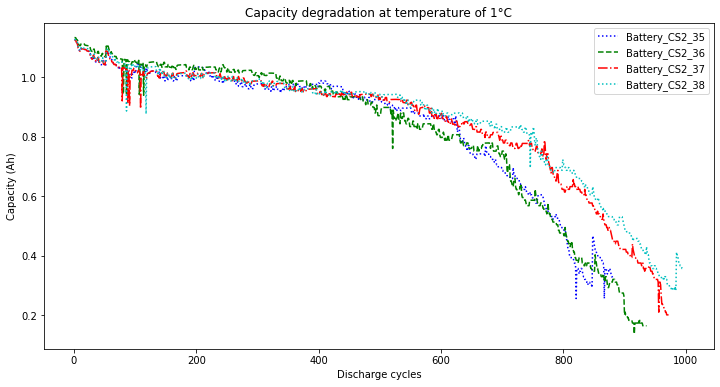

In [9]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 6))
color_list = ['b:', 'g--', 'r-.', 'c:']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at temperature of 1°C')
plt.legend()
plt.savefig("CALCE_Battery_Degradation.svg")

### Deninsing Transformer Architecture

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_dim=8, noise_level=0.001):
        super(Autoencoder, self).__init__()
        self.input_size, self.hidden_dim, self.noise_level = input_size, hidden_dim, noise_level
        self.fc1 = nn.Linear(self.input_size, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.input_size)
        
    def encoder(self, x):
        x = self.fc1(x)
        h1 = F.relu(x)
        return h1
    
    def mask(self, x):
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x
    
    def decoder(self, x):
        h2 = self.fc2(x)
        return h2
    
    def forward(self, x):
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=16):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].squeeze(1)
        return x    
    
    
class Net(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=32, num_layers=1, nhead=8, dropout=0.0, noise_level=0.01):
        super(Net, self).__init__()
        self.auto_hidden = int(feature_size/2)
        input_size = self.auto_hidden 
        self.pos = PositionalEncoding(d_model=input_size)
        encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.cell = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.linear1 = nn.Linear(input_size, 1)
        self.linear2 = nn.Linear(int(input_size/2), 1)
        self.autoencoder = Autoencoder(input_size=feature_size, hidden_dim=self.auto_hidden, noise_level=noise_level)
 
    def forward(self, x): 
        batch_size, feature_num, feature_size  = x.shape 
        encode, decode = self.autoencoder(x.reshape(batch_size, -1))# batch_size*seq_len
        out = encode.reshape(batch_size, -1, self.auto_hidden)
        out = self.pos(out)
        out = out.reshape(1, batch_size, -1) # (1, batch_size, feature_size)
        out = self.cell(out)                 # shape (1, batch_size, feature_size)
        out = out.reshape(batch_size, -1)    # (batch_size, hidden_dim)
        out = self.linear1(out)              # (batch_size, 1)
        
        return out, decode

## Model Training
### Functions for training

In [11]:
def train_step(model: torch.nn.Module,
               train_x: np.array,
               train_y: np.array,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  '''
  Performs training on a model.
  '''
  # put model in training mode
  model.train()

  X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32) # (batch_size, seq_len, input_size)
  y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)          # (batch_size, 1)

  X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)

  # Forward pass
  y_pred, decode = model(X)

  # Reshape y_pred
  y_pred = y_pred.reshape(-1, 1)

  loss = loss_fn(y_pred, y) + alpha * loss_fn(decode, X.reshape(-1, feature_size))

  # clear gradients for this training step
  optimizer.zero_grad()

  # backpropagation, compute gradients              
  loss.backward()  

  # apply gradients            
  optimizer.step()   

  return loss 

In [15]:
def test_step(model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              train_data: list,
              test_data: list,
              device: torch.device = device):   
  """
    Performs a testing loop step on model 
  """
  y_ = []
  model.eval()
  with torch.inference_mode():
    test_x = train_data.copy() 
    point_list = []
    while (len(test_x) - len(train_data)) < len(test_data):
        x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
        x = torch.from_numpy(x).to(device)   # shape (batch_size,feature_size=1,input_size)
        pred, _ = model(x)                   # pred shape: (batch_size=1, feature_size=1)
        next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
        test_x.append(next_point)      # The test values are added to the original sequence to continue to predict the next point
        point_list.append(next_point)  # Saves the predicted value of the last point in the output sequence
    y_.append(point_list)              # Save all the predicted values

    rmse = evaluation(y_test=test_data, y_predict=y_[-1])
    re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)

    return rmse, re

In [16]:
def train_model(lr=0.01, feature_size=8, hidden_dim=32, num_layers=1, nhead=8, weight_decay=0.0, EPOCH=1000, seed=0, 
                alpha=0.0, noise_level=0.0, dropout=0.0, metric='re', is_load_weights=True,
                leave_out = ['CS2_38'], device=device):
  
  # Define which batteries to train on
  train_list = Battery_list.copy()

  for entry in [leave_out]:
    train_list.pop(train_list.index(entry))

  # Setup seed
  setup_seed(seed)
  # define window size
  window_size = feature_size

  # Declare the model
  model = Net(feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, dropout=dropout,
              noise_level=noise_level)
  
  # send model to device
  model = model.to(device)
  # Declare optimizer and criterion (loss function)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  criterion = nn.MSELoss()  

  # load the weights if True
  if is_load_weights:
    checkpoint = f'transformer_CALCE_{leave_out}.pth'
    model.load_state_dict(torch.load(checkpoint))
    print(f"loaded {checkpoint}")
  else:
    print("Training model from scratch.")

  # Create dictionary for training data
  train_dict = {}
  for name in train_list:
    train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
    train_dict[name] = train_x, train_y, train_data, test_data

  # training loop
  loss_list = []
  for epoch in tqdm(range(EPOCH)):
    for name in train_list:
      train_x, train_y, train_data, test_data = train_dict[name]
      loss = train_step(model=model, train_x=train_x, train_y=train_y, loss_fn=criterion,
                        optimizer=optimizer,device=device)
      loss_list.append(loss)
      
      if (epoch+1)%200 == 0:
        rmse, re = test_step(model=model, loss_fn=criterion, 
                             train_data=train_data, test_data=test_data,
                             device=device)
        print(f'({name}) epoch:{epoch:<2d} | loss:{loss:<6.4f} | RMSE:{rmse:<6.4f} | RE:{re:<6.4f}')

  train_loss = 0
  for item in loss_list:
    train_loss = train_loss + item
  train_loss = train_loss/len(loss_list)
  print(f"Train loss: {train_loss:.5f}")

  return model

### Training loop
**Grid search results**

**optimal parameters of offline device: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, Win10**

Rated_Capacity = 1.1
window_size = 64
feature_size = window_size
dropout = 0.0
EPOCH = 500
nhead = 16
weight_decay = 0.0
noise_level = 0.0
alpha = 0.01
lr = 0.0005    # learning rate
hidden_dim = 32
num_layers = 1
is_load_weights = False
metric = 're'
re mean: 0.0536

Rated_Capacity = 1.1
window_size = 64
feature_size = window_size
dropout = 0.0
EPOCH = 500
nhead = 16
weight_decay = 0.0
noise_level = 0.0
alpha = 0.01
lr = 0.0005    # learning rate
hidden_dim = 32
num_layers = 1
is_load_weights = False
metric = 'rmse'
rmse mean: 0.0690

In [60]:
Rated_Capacity = 1.1
window_size = 64
feature_size = window_size
dropout = 0.0
EPOCH = 1000
nhead = 16
weight_decay = 0.0
noise_level = 0.0
alpha = 0.01
lr = 0.0001    # learning rate
hidden_dim = 32
num_layers = 2
is_load_weights = False
metric = 're'
threshold = 0.7

seed = 0
model = {}
print('seed:{}'.format(seed))


for leave_out in Battery_list:
  print(f"{'-'*64}\nTesting on: {leave_out}")
  for lr in [0.01, 0.001, 1e-4, 1e-5]:
    file = pathlib.Path(f"transformer_CALCE_{leave_out}.pth")
    if file.exists():
        print ("Resume training...")
        is_load_weights = True
    else:
        print ("Creating model...")
        is_load_weights = False

    print(f"\n<==== learning rate: {lr} ====>")
    model[leave_out] = train_model(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, 
                        weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha, 
                        noise_level=noise_level, metric=metric, is_load_weights=is_load_weights,
                        leave_out = leave_out, device=device)
    torch.save(model[leave_out].state_dict(), f'transformer_CALCE_{leave_out}.pth')


seed:0
----------------------------------------------------------------
Testing on: CS2_35
Creating model...

<==== learning rate: 0.01 ====>
Training model from scratch.


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_36) epoch:199 | loss:0.0003 | RMSE:0.0350 | RE:0.0225
(CS2_37) epoch:199 | loss:0.0004 | RMSE:0.1893 | RE:0.2400
(CS2_38) epoch:199 | loss:0.0004 | RMSE:0.1031 | RE:0.1389
(CS2_36) epoch:399 | loss:0.0004 | RMSE:0.3068 | RE:0.3782
(CS2_37) epoch:399 | loss:0.0004 | RMSE:0.2071 | RE:1.0000
(CS2_38) epoch:399 | loss:0.0003 | RMSE:0.0391 | RE:0.0449
(CS2_36) epoch:599 | loss:0.0003 | RMSE:0.3509 | RE:1.0000
(CS2_37) epoch:599 | loss:0.0004 | RMSE:0.5483 | RE:0.6769
(CS2_38) epoch:599 | loss:0.0004 | RMSE:0.2870 | RE:1.0000
(CS2_36) epoch:799 | loss:0.0003 | RMSE:0.4603 | RE:0.5630
(CS2_37) epoch:799 | loss:0.0003 | RMSE:0.2719 | RE:1.0000
(CS2_38) epoch:799 | loss:0.0003 | RMSE:0.3098 | RE:0.3343
(CS2_36) epoch:999 | loss:0.0002 | RMSE:0.3434 | RE:1.0000
(CS2_37) epoch:999 | loss:0.0002 | RMSE:0.3851 | RE:0.4600
(CS2_38) epoch:999 | loss:0.0002 | RMSE:0.2335 | RE:1.0000
Train loss: 0.00386
Resume training...

<==== learning rate: 0.001 ====>
loaded transformer_CALCE_CS2_35.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_36) epoch:199 | loss:0.0002 | RMSE:0.0815 | RE:0.1295
(CS2_37) epoch:199 | loss:0.0002 | RMSE:0.1281 | RE:0.2292
(CS2_38) epoch:199 | loss:0.0002 | RMSE:0.0564 | RE:0.0535
(CS2_36) epoch:399 | loss:0.0002 | RMSE:0.2939 | RE:1.0000
(CS2_37) epoch:399 | loss:0.0002 | RMSE:0.2713 | RE:1.0000
(CS2_38) epoch:399 | loss:0.0002 | RMSE:0.4369 | RE:0.5485
(CS2_36) epoch:599 | loss:0.0002 | RMSE:0.3135 | RE:1.0000
(CS2_37) epoch:599 | loss:0.0002 | RMSE:0.2663 | RE:1.0000
(CS2_38) epoch:599 | loss:0.0002 | RMSE:0.4437 | RE:0.5601
(CS2_36) epoch:799 | loss:0.0002 | RMSE:0.3263 | RE:1.0000
(CS2_37) epoch:799 | loss:0.0002 | RMSE:0.2584 | RE:1.0000
(CS2_38) epoch:799 | loss:0.0002 | RMSE:0.4461 | RE:0.5673
(CS2_36) epoch:999 | loss:0.0002 | RMSE:0.3380 | RE:1.0000
(CS2_37) epoch:999 | loss:0.0002 | RMSE:0.2371 | RE:1.0000
(CS2_38) epoch:999 | loss:0.0001 | RMSE:0.4509 | RE:0.5731
Train loss: 0.00017
Resume training...

<==== learning rate: 0.0001 ====>
loaded transformer_CALCE_CS2_35.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_36) epoch:199 | loss:0.0001 | RMSE:0.1098 | RE:0.1572
(CS2_37) epoch:199 | loss:0.0001 | RMSE:0.0765 | RE:0.1138
(CS2_38) epoch:199 | loss:0.0001 | RMSE:0.0629 | RE:0.0810
(CS2_36) epoch:399 | loss:0.0001 | RMSE:0.1162 | RE:0.1641
(CS2_37) epoch:399 | loss:0.0001 | RMSE:0.1285 | RE:0.2108
(CS2_38) epoch:399 | loss:0.0001 | RMSE:0.1149 | RE:0.1433
(CS2_36) epoch:599 | loss:0.0001 | RMSE:0.1258 | RE:0.1796
(CS2_37) epoch:599 | loss:0.0001 | RMSE:0.1448 | RE:0.2508
(CS2_38) epoch:599 | loss:0.0001 | RMSE:0.1248 | RE:0.1592
(CS2_36) epoch:799 | loss:0.0001 | RMSE:0.1304 | RE:0.1865
(CS2_37) epoch:799 | loss:0.0001 | RMSE:0.1581 | RE:0.2877
(CS2_38) epoch:799 | loss:0.0001 | RMSE:0.1317 | RE:0.1664
(CS2_36) epoch:999 | loss:0.0001 | RMSE:0.1296 | RE:0.1831
(CS2_37) epoch:999 | loss:0.0001 | RMSE:0.1794 | RE:0.3554
(CS2_38) epoch:999 | loss:0.0001 | RMSE:0.1404 | RE:0.1737
Train loss: 0.00013
Resume training...

<==== learning rate: 1e-05 ====>
loaded transformer_CALCE_CS2_35.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_36) epoch:199 | loss:0.0001 | RMSE:0.1314 | RE:0.1865
(CS2_37) epoch:199 | loss:0.0001 | RMSE:0.0468 | RE:0.0569
(CS2_38) epoch:199 | loss:0.0001 | RMSE:0.0309 | RE:0.0188
(CS2_36) epoch:399 | loss:0.0001 | RMSE:0.1311 | RE:0.1831
(CS2_37) epoch:399 | loss:0.0001 | RMSE:0.0502 | RE:0.0600
(CS2_38) epoch:399 | loss:0.0001 | RMSE:0.0309 | RE:0.0217
(CS2_36) epoch:599 | loss:0.0001 | RMSE:0.1317 | RE:0.1848
(CS2_37) epoch:599 | loss:0.0001 | RMSE:0.0523 | RE:0.0631
(CS2_38) epoch:599 | loss:0.0001 | RMSE:0.0313 | RE:0.0203
(CS2_36) epoch:799 | loss:0.0001 | RMSE:0.1327 | RE:0.1865
(CS2_37) epoch:799 | loss:0.0001 | RMSE:0.0552 | RE:0.0677
(CS2_38) epoch:799 | loss:0.0001 | RMSE:0.0322 | RE:0.0174
(CS2_36) epoch:999 | loss:0.0001 | RMSE:0.1337 | RE:0.1883
(CS2_37) epoch:999 | loss:0.0001 | RMSE:0.0570 | RE:0.0708
(CS2_38) epoch:999 | loss:0.0001 | RMSE:0.0326 | RE:0.0159
Train loss: 0.00012
----------------------------------------------------------------
Testing on: CS2_36
Creating mo

  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0004 | RMSE:0.0496 | RE:0.0662
(CS2_37) epoch:199 | loss:0.0004 | RMSE:0.1192 | RE:0.1292
(CS2_38) epoch:199 | loss:0.0004 | RMSE:0.0343 | RE:0.0203
(CS2_35) epoch:399 | loss:0.0005 | RMSE:0.3050 | RE:0.3606
(CS2_37) epoch:399 | loss:0.0003 | RMSE:0.3995 | RE:0.4692
(CS2_38) epoch:399 | loss:0.0003 | RMSE:0.2738 | RE:1.0000
(CS2_35) epoch:599 | loss:0.0002 | RMSE:0.2680 | RE:1.0000
(CS2_37) epoch:599 | loss:0.0003 | RMSE:0.0813 | RE:0.0738
(CS2_38) epoch:599 | loss:0.0003 | RMSE:0.2867 | RE:0.3343
(CS2_35) epoch:799 | loss:0.0003 | RMSE:0.2693 | RE:1.0000
(CS2_37) epoch:799 | loss:0.0005 | RMSE:0.5856 | RE:0.7831
(CS2_38) epoch:799 | loss:0.0006 | RMSE:0.2596 | RE:1.0000
(CS2_35) epoch:999 | loss:0.0002 | RMSE:0.2568 | RE:1.0000
(CS2_37) epoch:999 | loss:0.0002 | RMSE:0.4029 | RE:0.5123
(CS2_38) epoch:999 | loss:0.0002 | RMSE:0.2807 | RE:1.0000
Train loss: 0.00458
Resume training...

<==== learning rate: 0.001 ====>
loaded transformer_CALCE_CS2_36.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0002 | RMSE:0.1030 | RE:0.1916
(CS2_37) epoch:199 | loss:0.0002 | RMSE:0.0887 | RE:0.1492
(CS2_38) epoch:199 | loss:0.0002 | RMSE:0.0950 | RE:0.1085
(CS2_35) epoch:399 | loss:0.0002 | RMSE:0.2660 | RE:1.0000
(CS2_37) epoch:399 | loss:0.0002 | RMSE:0.2713 | RE:1.0000
(CS2_38) epoch:399 | loss:0.0002 | RMSE:0.4612 | RE:0.6035
(CS2_35) epoch:599 | loss:0.0002 | RMSE:0.2754 | RE:1.0000
(CS2_37) epoch:599 | loss:0.0002 | RMSE:0.2670 | RE:1.0000
(CS2_38) epoch:599 | loss:0.0002 | RMSE:0.4698 | RE:0.6194
(CS2_35) epoch:799 | loss:0.0002 | RMSE:0.2795 | RE:1.0000
(CS2_37) epoch:799 | loss:0.0002 | RMSE:0.2589 | RE:1.0000
(CS2_38) epoch:799 | loss:0.0002 | RMSE:0.4686 | RE:0.6151
(CS2_35) epoch:999 | loss:0.0002 | RMSE:0.2842 | RE:1.0000
(CS2_37) epoch:999 | loss:0.0002 | RMSE:0.2501 | RE:1.0000
(CS2_38) epoch:999 | loss:0.0001 | RMSE:0.4734 | RE:0.6194
Train loss: 0.00018
Resume training...

<==== learning rate: 0.0001 ====>
loaded transformer_CALCE_CS2_36.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0001 | RMSE:0.1285 | RE:0.2474
(CS2_37) epoch:199 | loss:0.0001 | RMSE:0.1079 | RE:0.1815
(CS2_38) epoch:199 | loss:0.0001 | RMSE:0.1062 | RE:0.1187
(CS2_35) epoch:399 | loss:0.0001 | RMSE:0.1438 | RE:0.2857
(CS2_37) epoch:399 | loss:0.0001 | RMSE:0.1491 | RE:0.2692
(CS2_38) epoch:399 | loss:0.0001 | RMSE:0.1430 | RE:0.1621
(CS2_35) epoch:599 | loss:0.0001 | RMSE:0.1499 | RE:0.3014
(CS2_37) epoch:599 | loss:0.0001 | RMSE:0.1603 | RE:0.2985
(CS2_38) epoch:599 | loss:0.0001 | RMSE:0.1552 | RE:0.1766
(CS2_35) epoch:799 | loss:0.0001 | RMSE:0.1559 | RE:0.3188
(CS2_37) epoch:799 | loss:0.0001 | RMSE:0.1698 | RE:0.3262
(CS2_38) epoch:799 | loss:0.0001 | RMSE:0.1662 | RE:0.1910
(CS2_35) epoch:999 | loss:0.0001 | RMSE:0.1627 | RE:0.3397
(CS2_37) epoch:999 | loss:0.0001 | RMSE:0.1756 | RE:0.3446
(CS2_38) epoch:999 | loss:0.0001 | RMSE:0.1763 | RE:0.2041
Train loss: 0.00014
Resume training...

<==== learning rate: 1e-05 ====>
loaded transformer_CALCE_CS2_36.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0001 | RMSE:0.1172 | RE:0.2213
(CS2_37) epoch:199 | loss:0.0001 | RMSE:0.0537 | RE:0.0923
(CS2_38) epoch:199 | loss:0.0001 | RMSE:0.0225 | RE:0.0014
(CS2_35) epoch:399 | loss:0.0001 | RMSE:0.1179 | RE:0.2230
(CS2_37) epoch:399 | loss:0.0001 | RMSE:0.0549 | RE:0.0938
(CS2_38) epoch:399 | loss:0.0001 | RMSE:0.0225 | RE:0.0029
(CS2_35) epoch:599 | loss:0.0001 | RMSE:0.1187 | RE:0.2247
(CS2_37) epoch:599 | loss:0.0001 | RMSE:0.0564 | RE:0.0969
(CS2_38) epoch:599 | loss:0.0001 | RMSE:0.0223 | RE:0.0014
(CS2_35) epoch:799 | loss:0.0001 | RMSE:0.1193 | RE:0.2265
(CS2_37) epoch:799 | loss:0.0001 | RMSE:0.0570 | RE:0.0985
(CS2_38) epoch:799 | loss:0.0001 | RMSE:0.0221 | RE:0.0014
(CS2_35) epoch:999 | loss:0.0001 | RMSE:0.1203 | RE:0.2282
(CS2_37) epoch:999 | loss:0.0001 | RMSE:0.0590 | RE:0.1015
(CS2_38) epoch:999 | loss:0.0001 | RMSE:0.0218 | RE:0.0000
Train loss: 0.00013
----------------------------------------------------------------
Testing on: CS2_37
Creating mo

  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0004 | RMSE:0.2856 | RE:1.0000
(CS2_36) epoch:199 | loss:0.0004 | RMSE:0.3349 | RE:0.4750
(CS2_38) epoch:199 | loss:0.0005 | RMSE:0.2602 | RE:1.0000
(CS2_35) epoch:399 | loss:0.0005 | RMSE:0.3103 | RE:1.0000
(CS2_36) epoch:399 | loss:0.0007 | RMSE:0.5224 | RE:0.7599
(CS2_38) epoch:399 | loss:0.0010 | RMSE:0.3110 | RE:1.0000
(CS2_35) epoch:599 | loss:0.0003 | RMSE:0.4044 | RE:0.5453
(CS2_36) epoch:599 | loss:0.0003 | RMSE:0.3509 | RE:1.0000
(CS2_38) epoch:599 | loss:0.0003 | RMSE:0.4890 | RE:0.6744
(CS2_35) epoch:799 | loss:0.0002 | RMSE:0.4326 | RE:0.5749
(CS2_36) epoch:799 | loss:0.0003 | RMSE:0.3628 | RE:1.0000
(CS2_38) epoch:799 | loss:0.0003 | RMSE:0.5838 | RE:0.7873
(CS2_35) epoch:999 | loss:0.0003 | RMSE:0.5510 | RE:0.7334
(CS2_36) epoch:999 | loss:0.0004 | RMSE:0.3590 | RE:1.0000
(CS2_38) epoch:999 | loss:0.0004 | RMSE:0.6184 | RE:0.8234
Train loss: 0.00390
Resume training...

<==== learning rate: 0.001 ====>
loaded transformer_CALCE_CS2_37.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0002 | RMSE:0.0565 | RE:0.1010
(CS2_36) epoch:199 | loss:0.0002 | RMSE:0.2272 | RE:0.4266
(CS2_38) epoch:199 | loss:0.0002 | RMSE:0.1209 | RE:0.1476
(CS2_35) epoch:399 | loss:0.0002 | RMSE:0.2475 | RE:1.0000
(CS2_36) epoch:399 | loss:0.0002 | RMSE:0.3373 | RE:1.0000
(CS2_38) epoch:399 | loss:0.0002 | RMSE:0.4307 | RE:0.5572
(CS2_35) epoch:599 | loss:0.0002 | RMSE:0.2620 | RE:1.0000
(CS2_36) epoch:599 | loss:0.0001 | RMSE:0.3391 | RE:1.0000
(CS2_38) epoch:599 | loss:0.0002 | RMSE:0.4312 | RE:0.5687
(CS2_35) epoch:799 | loss:0.0002 | RMSE:0.2784 | RE:1.0000
(CS2_36) epoch:799 | loss:0.0001 | RMSE:0.3447 | RE:1.0000
(CS2_38) epoch:799 | loss:0.0002 | RMSE:0.4337 | RE:0.5774
(CS2_35) epoch:999 | loss:0.0002 | RMSE:0.2838 | RE:1.0000
(CS2_36) epoch:999 | loss:0.0001 | RMSE:0.3428 | RE:1.0000
(CS2_38) epoch:999 | loss:0.0002 | RMSE:0.4391 | RE:0.5861
Train loss: 0.00017
Resume training...

<==== learning rate: 0.0001 ====>
loaded transformer_CALCE_CS2_37.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0001 | RMSE:0.0675 | RE:0.1202
(CS2_36) epoch:199 | loss:0.0001 | RMSE:0.1643 | RE:0.2625
(CS2_38) epoch:199 | loss:0.0001 | RMSE:0.1003 | RE:0.1230
(CS2_35) epoch:399 | loss:0.0001 | RMSE:0.0820 | RE:0.1481
(CS2_36) epoch:399 | loss:0.0001 | RMSE:0.2013 | RE:0.3506
(CS2_38) epoch:399 | loss:0.0001 | RMSE:0.1233 | RE:0.1491
(CS2_35) epoch:599 | loss:0.0001 | RMSE:0.0891 | RE:0.1620
(CS2_36) epoch:599 | loss:0.0001 | RMSE:0.2136 | RE:0.3851
(CS2_38) epoch:599 | loss:0.0001 | RMSE:0.1301 | RE:0.1563
(CS2_35) epoch:799 | loss:0.0001 | RMSE:0.0891 | RE:0.1620
(CS2_36) epoch:799 | loss:0.0001 | RMSE:0.2306 | RE:0.4439
(CS2_38) epoch:799 | loss:0.0001 | RMSE:0.1323 | RE:0.1592
(CS2_35) epoch:999 | loss:0.0001 | RMSE:0.0891 | RE:0.1620
(CS2_36) epoch:999 | loss:0.0001 | RMSE:0.2390 | RE:0.4801
(CS2_38) epoch:999 | loss:0.0001 | RMSE:0.1363 | RE:0.1635
Train loss: 0.00013
Resume training...

<==== learning rate: 1e-05 ====>
loaded transformer_CALCE_CS2_37.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0001 | RMSE:0.0958 | RE:0.1760
(CS2_36) epoch:199 | loss:0.0001 | RMSE:0.1393 | RE:0.2142
(CS2_38) epoch:199 | loss:0.0001 | RMSE:0.0274 | RE:0.0232
(CS2_35) epoch:399 | loss:0.0001 | RMSE:0.0968 | RE:0.1777
(CS2_36) epoch:399 | loss:0.0001 | RMSE:0.1410 | RE:0.2176
(CS2_38) epoch:399 | loss:0.0001 | RMSE:0.0272 | RE:0.0232
(CS2_35) epoch:599 | loss:0.0001 | RMSE:0.0979 | RE:0.1794
(CS2_36) epoch:599 | loss:0.0001 | RMSE:0.1426 | RE:0.2211
(CS2_38) epoch:599 | loss:0.0001 | RMSE:0.0264 | RE:0.0217
(CS2_35) epoch:799 | loss:0.0001 | RMSE:0.0990 | RE:0.1812
(CS2_36) epoch:799 | loss:0.0001 | RMSE:0.1442 | RE:0.2228
(CS2_38) epoch:799 | loss:0.0001 | RMSE:0.0257 | RE:0.0203
(CS2_35) epoch:999 | loss:0.0001 | RMSE:0.1001 | RE:0.1847
(CS2_36) epoch:999 | loss:0.0001 | RMSE:0.1459 | RE:0.2263
(CS2_38) epoch:999 | loss:0.0001 | RMSE:0.0249 | RE:0.0188
Train loss: 0.00013
----------------------------------------------------------------
Testing on: CS2_38
Creating mo

  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0004 | RMSE:0.2764 | RE:1.0000
(CS2_36) epoch:199 | loss:0.0005 | RMSE:0.3230 | RE:0.4611
(CS2_37) epoch:199 | loss:0.0006 | RMSE:0.2432 | RE:1.0000
(CS2_35) epoch:399 | loss:0.0003 | RMSE:0.3256 | RE:0.4164
(CS2_36) epoch:399 | loss:0.0003 | RMSE:0.3293 | RE:1.0000
(CS2_37) epoch:399 | loss:0.0003 | RMSE:0.2771 | RE:0.3492
(CS2_35) epoch:599 | loss:0.0003 | RMSE:0.2445 | RE:1.0000
(CS2_36) epoch:599 | loss:0.0002 | RMSE:0.3068 | RE:1.0000
(CS2_37) epoch:599 | loss:0.0003 | RMSE:0.3873 | RE:0.4492
(CS2_35) epoch:799 | loss:0.0004 | RMSE:0.2571 | RE:1.0000
(CS2_36) epoch:799 | loss:0.0002 | RMSE:0.3359 | RE:1.0000
(CS2_37) epoch:799 | loss:0.0003 | RMSE:0.5763 | RE:0.7631
(CS2_35) epoch:999 | loss:0.0002 | RMSE:0.2114 | RE:0.1916
(CS2_36) epoch:999 | loss:0.0002 | RMSE:0.3392 | RE:1.0000
(CS2_37) epoch:999 | loss:0.0002 | RMSE:0.4663 | RE:0.6000
Train loss: 0.00392
Resume training...

<==== learning rate: 0.001 ====>
loaded transformer_CALCE_CS2_38.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0002 | RMSE:0.0926 | RE:0.1638
(CS2_36) epoch:199 | loss:0.0002 | RMSE:0.1146 | RE:0.1710
(CS2_37) epoch:199 | loss:0.0002 | RMSE:0.0535 | RE:0.0477
(CS2_35) epoch:399 | loss:0.0002 | RMSE:0.2519 | RE:1.0000
(CS2_36) epoch:399 | loss:0.0002 | RMSE:0.0935 | RE:0.0933
(CS2_37) epoch:399 | loss:0.0002 | RMSE:0.1336 | RE:0.2246
(CS2_35) epoch:599 | loss:0.0001 | RMSE:0.1797 | RE:0.2021
(CS2_36) epoch:599 | loss:0.0001 | RMSE:0.3362 | RE:1.0000
(CS2_37) epoch:599 | loss:0.0002 | RMSE:0.3009 | RE:0.3646
(CS2_35) epoch:799 | loss:0.0001 | RMSE:0.1888 | RE:1.0000
(CS2_36) epoch:799 | loss:0.0001 | RMSE:0.1215 | RE:0.1503
(CS2_37) epoch:799 | loss:0.0002 | RMSE:0.2158 | RE:1.0000
(CS2_35) epoch:999 | loss:0.0001 | RMSE:0.1495 | RE:0.2997
(CS2_36) epoch:999 | loss:0.0001 | RMSE:0.0279 | RE:0.0121
(CS2_37) epoch:999 | loss:0.0001 | RMSE:0.0932 | RE:0.1462
Train loss: 0.00017
Resume training...

<==== learning rate: 0.0001 ====>
loaded transformer_CALCE_CS2_38.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0001 | RMSE:0.1131 | RE:0.2038
(CS2_36) epoch:199 | loss:0.0001 | RMSE:0.1551 | RE:0.2383
(CS2_37) epoch:199 | loss:0.0001 | RMSE:0.0309 | RE:0.0123
(CS2_35) epoch:399 | loss:0.0001 | RMSE:0.1392 | RE:0.2683
(CS2_36) epoch:399 | loss:0.0001 | RMSE:0.2111 | RE:0.3748
(CS2_37) epoch:399 | loss:0.0001 | RMSE:0.0978 | RE:0.1015
(CS2_35) epoch:599 | loss:0.0001 | RMSE:0.1552 | RE:0.3188
(CS2_36) epoch:599 | loss:0.0001 | RMSE:0.2318 | RE:0.4508
(CS2_37) epoch:599 | loss:0.0001 | RMSE:0.1283 | RE:0.1400
(CS2_35) epoch:799 | loss:0.0001 | RMSE:0.1591 | RE:0.3310
(CS2_36) epoch:799 | loss:0.0001 | RMSE:0.2213 | RE:0.4093
(CS2_37) epoch:799 | loss:0.0001 | RMSE:0.1320 | RE:0.1431
(CS2_35) epoch:999 | loss:0.0001 | RMSE:0.1707 | RE:0.3746
(CS2_36) epoch:999 | loss:0.0001 | RMSE:0.2420 | RE:0.4940
(CS2_37) epoch:999 | loss:0.0001 | RMSE:0.1413 | RE:0.1569
Train loss: 0.00013
Resume training...

<==== learning rate: 1e-05 ====>
loaded transformer_CALCE_CS2_38.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

(CS2_35) epoch:199 | loss:0.0001 | RMSE:0.1249 | RE:0.2300
(CS2_36) epoch:199 | loss:0.0001 | RMSE:0.1647 | RE:0.2573
(CS2_37) epoch:199 | loss:0.0001 | RMSE:0.0317 | RE:0.0523
(CS2_35) epoch:399 | loss:0.0001 | RMSE:0.1315 | RE:0.2474
(CS2_36) epoch:399 | loss:0.0001 | RMSE:0.1719 | RE:0.2729
(CS2_37) epoch:399 | loss:0.0001 | RMSE:0.0333 | RE:0.0554
(CS2_35) epoch:599 | loss:0.0001 | RMSE:0.1303 | RE:0.2439
(CS2_36) epoch:599 | loss:0.0001 | RMSE:0.1716 | RE:0.2712
(CS2_37) epoch:599 | loss:0.0001 | RMSE:0.0355 | RE:0.0585
(CS2_35) epoch:799 | loss:0.0001 | RMSE:0.1338 | RE:0.2526
(CS2_36) epoch:799 | loss:0.0001 | RMSE:0.1755 | RE:0.2798
(CS2_37) epoch:799 | loss:0.0001 | RMSE:0.0382 | RE:0.0631
(CS2_35) epoch:999 | loss:0.0001 | RMSE:0.1359 | RE:0.2578
(CS2_36) epoch:999 | loss:0.0001 | RMSE:0.1784 | RE:0.2867
(CS2_37) epoch:999 | loss:0.0001 | RMSE:0.0416 | RE:0.0692
Train loss: 0.00013


### Test Inference

#### One-Step Ahead

In [19]:
def split_seq(sequence, window_size=8, end=1):
  '''
  Splits an input sequence by a defined window size up to a defined portion of the sequence.
  Outputs array X with window_size steps and array y with the next step.

  Keyword arguments:
  ------------------
  sequence -- the  sequence to be split
  window_size -- sequence length of X (default: 8)
  end -- define what percent of the sequence to include (default: 1)
  '''
  # define empty variable
  X, y = [], []


  for i in range(len(sequence)):

    # compute end index
    end_i = i + window_size

    # check if end of the sequence is reached; break if end is reached
    if (end_i) > ( round(len(sequence)*end) - 1):
      break

    seq_x, seq_y = sequence[i:end_i], sequence[end_i] 
    X.append(seq_x)
    y.append(seq_y)

  return np.array(X), np.array(y)

def create_test_tensor(Battery,
                       leave_out=['B0018'],
                       window_size=16,
                       test_split = 0.4,
                       end=1):
  
  for item in leave_out:
    # For one-step ahead
    df_result = Battery[item]
    Cycle, Capacity = df_result['cycle'], df_result['capacity']
    X_cap, y_cap = split_seq(Capacity, window_size, end)
    data_points = len(X_cap)
    test_split_idx = round(test_split * data_points)

    X_test = X_cap[(test_split_idx):]
    y_test = y_cap[(test_split_idx):]
    y_test = y_test.reshape(-1,1)

    # For iterative multi-step ahead
    data_points_test = len(Capacity)

    # Create tuple for test
    test_sequence = Capacity[:(test_split_idx)], Cycle[:(test_split_idx)]
    test_labels = Capacity[(test_split_idx):], Cycle[(test_split_idx):]

  return torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32), test_sequence, test_labels

def accuracy(y_test: torch.tensor, y_pred: torch.tensor):
  error = torch.abs(y_pred-y_test)/y_test
  acc = 1 - error
  return float(acc)

Perform one-step ahead prediction

Performance on Test Data CS2_35:
Accuracy: 98.21562%	MAE: 0.00874	RMSE: 0.00026
RUL True: 85		RUL Pred: 86	RUL Error: -1
----------------------------------------------------------------
Performance on Test Data CS2_36:
Accuracy: 97.93755%	MAE: 0.00917	RMSE: 0.00014
RUL True: 58		RUL Pred: 53	RUL Error: 5
----------------------------------------------------------------
Performance on Test Data CS2_37:
Accuracy: 98.56048%	MAE: 0.00760	RMSE: 0.00013
RUL True: 107		RUL Pred: 108	RUL Error: -1
----------------------------------------------------------------
Performance on Test Data CS2_38:
Accuracy: 98.49874%	MAE: 0.00821	RMSE: 0.00017
RUL True: 122		RUL Pred: 136	RUL Error: -14
----------------------------------------------------------------


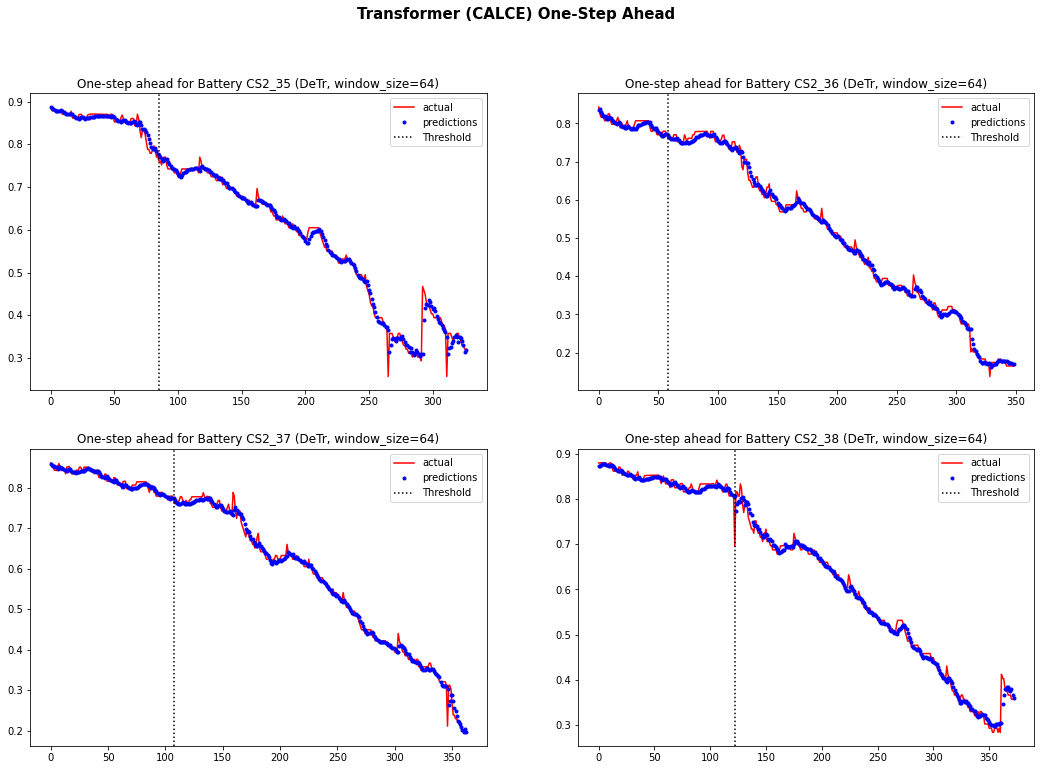

In [61]:
test_sequence, test_labels = {}, {}
X_test, y_test = {}, {}
plt.figure(figsize=(18,12))
plt.suptitle('Transformer (CALCE) One-Step Ahead',fontsize=15, weight='bold')

for leave_out, idx in zip(Battery_list, range(len(Battery_list))):
  # Generate test tensor
  X_test[leave_out], y_test[leave_out], test_sequence[leave_out], test_labels[leave_out] = create_test_tensor(Battery,
                                                                                            leave_out=[leave_out],
                                                                                            window_size=window_size,
                                                                                            test_split = 0.6)
  # Send to device
  X_test[leave_out], y_test[leave_out] = X_test[leave_out].to(device), y_test[leave_out].to(device)

  model[leave_out].eval()
  acc = 0
  pred = []

  with torch.inference_mode():
    for test_tensor, label in zip(X_test[leave_out], y_test[leave_out]):
      test_tensor = test_tensor.to(device)
      preds, _ = model[leave_out]((test_tensor/Rated_Capacity).reshape(-1,1,window_size))
      pred.append(preds)
      acc += accuracy(preds*Rated_Capacity, label.to(device))

  #pred = torch.cat(pred)
  pred = torch.tensor(pred) * Rated_Capacity
  acc = acc/len(y_test[leave_out]) * 100
  mae = mean_absolute_error(y_test[leave_out].cpu(),pred)
  rmse = mean_squared_error(y_test[leave_out].cpu(),pred)
  print(f"Performance on Test Data {leave_out}:\nAccuracy: {acc:.5f}%\tMAE: {mae:.5f}\tRMSE: {rmse:.5f}")

  # Compute where EOL occurs (70% (threshold) of rated capacity)
  idx_test = (y_test[leave_out] < Rated_Capacity*threshold).nonzero(as_tuple=True)
  rul_test = idx_test[0][0]
  idx_pred = (pred < Rated_Capacity*threshold).nonzero(as_tuple=True)
  rul_pred = idx_pred[0][0]
  print(f"RUL True: {rul_test}\t\tRUL Pred: {rul_pred}\tRUL Error: {rul_test - rul_pred}\n{'-'*64}")

  # Plot
  plt.subplot(2,2,idx+1)
  plt.plot(y_test[leave_out].cpu(),'r-',label="actual")
  plt.plot(pred.cpu(),'b.',label="predictions")
  plt.axvline(rul_test.cpu(), color='k', linestyle=':', label='Threshold')
  plt.title(f"One-step ahead for Battery {leave_out} (DeTr, window_size={window_size})")
  plt.legend()

torch.save((X_test, y_test, test_sequence, test_labels),'test_tensors_Transformer_CALCE.pt')

In [68]:
!mv transformer_CALCE_CS2_35.pth checkpoints/transformer_CALCE_CS2_35.pth
!mv transformer_CALCE_CS2_36.pth checkpoints/transformer_CALCE_CS2_36.pth
!mv transformer_CALCE_CS2_37.pth checkpoints/transformer_CALCE_CS2_37.pth
!mv transformer_CALCE_CS2_38.pth checkpoints/transformer_CALCE_CS2_38.pth
!zip -r checkpoints_Transformer_CALCE.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/transformer_CALCE_CS2_37.pth (deflated 26%)
  adding: checkpoints/transformer_CALCE_CS2_36.pth (deflated 26%)
  adding: checkpoints/transformer_CALCE_CS2_35.pth (deflated 26%)
  adding: checkpoints/transformer_CALCE_CS2_38.pth (deflated 26%)


#### Iterative Multi-Step Ahead

In [63]:
def plot_predictions(train_cap, train_cyc, label_cap, label_cyc, predictions, title):
  plt.title(title)
  plt.plot(train_cyc, train_cap, 'k-', label='Test data')
  plt.plot(label_cyc, label_cap, 'k:', label='Target')
  plt.plot(label_cyc, predictions, 'b-', label='Predicted')
  plt.legend()
  plt.xlabel('Number of Discharge Cycles')
  plt.ylabel('Capacity (in Ah)')

Performance for CS2_35:
Acc:86.16374%	MAE: 0.0650	RMSE: 0.0875
RUL True: 149	RUL Pred: 199	RUL Error: 50
----------------------------------------------------------------
Performance for CS2_36:
Acc:90.74505%	MAE: 0.0452	RMSE: 0.0566
RUL True: 122	RUL Pred: 103	RUL Error: -19
----------------------------------------------------------------
Performance for CS2_37:
Acc:95.95558%	MAE: 0.0194	RMSE: 0.0259
RUL True: 171	RUL Pred: 181	RUL Error: 10
----------------------------------------------------------------
Performance for CS2_38:
Acc:95.39159%	MAE: 0.0256	RMSE: 0.0315
RUL True: 186	RUL Pred: 180	RUL Error: -6
----------------------------------------------------------------


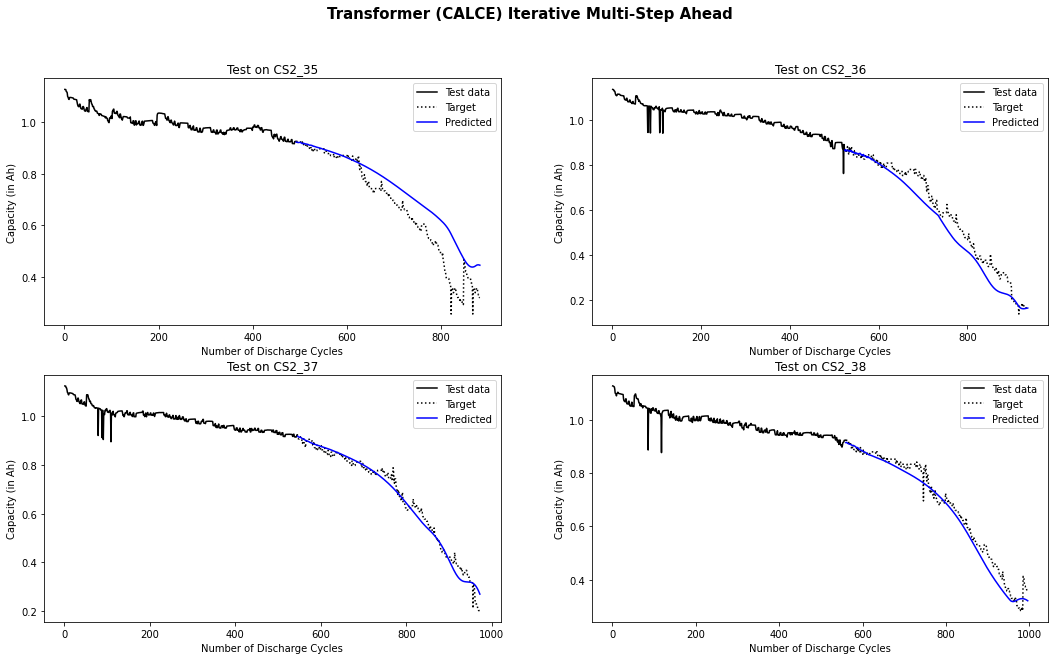

In [64]:
plt.figure(figsize=(18,10))
plt.suptitle('Transformer (CALCE) Iterative Multi-Step Ahead',fontsize=15, weight='bold')

for leave_out, idx in zip(Battery_list, range(len(Battery_list)) ):
  eval_cap, eval_cyc = test_sequence[leave_out]
  test_cap, test_cyc = test_labels[leave_out]

  # convert lists to tensors
  eval_cap, eval_cyc = eval_cap, eval_cyc
  test_cap, test_cyc = np.array(test_cap), np.array(test_cyc)

  # create point list which contains predictions
  preds = []
  # sequence which contains prediction inputs (last window_size entries of array)
  seq = eval_cap[-window_size:].tolist()

  model[leave_out].eval()
  with torch.inference_mode():
    for j in range(len(test_cap)):
      pred, _ = model[leave_out](torch.tensor(seq, dtype=torch.float32, device=device).reshape(-1,1,window_size)/Rated_Capacity)
      seq = seq[1:]
      seq.append(np.float64(pred * Rated_Capacity))
      preds.append(np.float64(pred * Rated_Capacity))

  # copy preds to dictionary
  preds = np.array(preds)


  # plot predictions
  plt.subplot(2,2,idx+1)
  plot_predictions(train_cap = eval_cap,
                    train_cyc = eval_cyc,
                    label_cap = test_cap,
                    label_cyc = test_cyc,
                    predictions = preds,
                    title = f"Test on {leave_out}")

  # Print accuracy
  error = np.abs(preds - test_cap)/test_cap
  acc = np.ones_like(error)- error
  acc = np.sum(acc)/len(test_cap)*100
  mae = mean_absolute_error(test_cap,preds)
  rmse = sqrt(mean_squared_error(test_cap,preds))
  print(f"Performance for {leave_out}:\nAcc:{acc:.5f}%\tMAE: {mae:.4f}\tRMSE: {rmse:.4f}")

  # Compute where EOL occurs (70% (threshold) of rated capacity)
  idx_test = (torch.tensor(test_cap) < Rated_Capacity*threshold).nonzero(as_tuple=True)
  rul_test = idx_test[0][0]
  idx_pred = (torch.tensor(preds) < Rated_Capacity*threshold).nonzero(as_tuple=True)
  rul_pred = idx_pred[0][0]
  print(f"RUL True: {rul_test}\tRUL Pred: {rul_pred}\tRUL Error: {rul_pred - rul_test}\n{'-'*64}")

## Printing Model Summary

In [67]:
from torchinfo import summary
for leave_out in Battery_list:
  print(summary(model[leave_out],input_size=(1,1,feature_size),device='cpu'))

Layer (type:depth-idx)                        Output Shape              Param #
Net                                           [1, 1]                    17
├─Autoencoder: 1-1                            [1, 32]                   --
│    └─Linear: 2-1                            [1, 32]                   2,080
│    └─Linear: 2-2                            [1, 64]                   2,112
├─PositionalEncoding: 1-2                     [1, 1, 32]                --
├─TransformerEncoder: 1-3                     [1, 1, 32]                --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 1, 32]                6,464
│    │    └─TransformerEncoderLayer: 3-2      [1, 1, 32]                6,464
├─Linear: 1-4                                 [1, 1]                    33
Total params: 17,170
Trainable params: 17,170
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Pa

## Old training functions/loop

In [ ]:
def train(lr=0.01, feature_size=8, hidden_dim=32, num_layers=1, nhead=8, weight_decay=0.0, EPOCH=1000, seed=0, 
         alpha=0.0, noise_level=0.0, dropout=0.0, metric='re', is_load_weights=True):
    score_list, result_list = [], []
    
    for i in range(4):
        name = Battery_list[i]
        window_size = feature_size
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
        train_size = len(train_x)
        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = Net(feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, dropout=dropout,
                    noise_level=noise_level)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        '''
        # save ramdom data for repetition
        if torch.__version__.split('+')[0] >= '1.6.0':
            torch.save(model.state_dict(), 'model_CALCE'+str(seed)+'.pth')
        else:
            torch.save(model.state_dict(), 'model_CALCE.pth', _use_new_zipfile_serialization=False)
         '''

        # load the random data generated by my device
        if is_load_weights: 
            if torch.__version__.split('+')[0] >= '1.6.0':
                model.load_state_dict(torch.load('initial_weights/model_CALCE.pth')) 
            else:
                model.load_state_dict(torch.load('initial_weights/model_CALCE_1.5.0.pth'))
                
        test_x = train_data.copy()
        loss_list, y_ = [0], []
        rmse, re = 1, 1
        score_, score = [1], [1]
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)#(batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)# shape 为 (batch_size, 1)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output, decode = model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y) + alpha * criterion(decode, X.reshape(-1, feature_size))
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy()
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device) # (batch_size,feature_size=1,input_size)
                    pred, _ = model(x)                 # pred shape (batch_size=1, feature_size=1)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)     # The test values are added to the original sequence to continue to predict the next point
                    point_list.append(next_point) # Saves the predicted value of the last point in the output sequence
                y_.append(point_list)             # Save all the predicted values
                loss_list.append(loss)
                rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))
            if metric == 're':
                score = [re]
            elif metric == 'rmse':
                score = [rmse]
            else:
                score = [re, rmse]
            if (loss < 0.001) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list, y_, model, test_data

In [ ]:
Rated_Capacity = 1.1
window_size = 64
feature_size = window_size
dropout = 0.0
EPOCH = 500
nhead = 16
weight_decay = 0.0
noise_level = 0.0
alpha = 0.01
lr = 0.0005    # learning rate
hidden_dim = 32
num_layers = 1
is_load_weights = False
metric = 're'

seed = 0
SCORE = []
print('seed:{}'.format(seed))
score_list, result_list, y_data, model, test_data = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, 
                                                          weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha, 
                                                          noise_level=noise_level, metric=metric, is_load_weights=is_load_weights)
print(np.array(score_list))
print(metric + ': {:<6.4f}'.format(np.mean(np.array(score_list))))
print('------------------------------------------------------------------')
for s in score_list:
    SCORE.append(s)

print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

seed:0
sample size: 2713
epoch:0  | loss:1.4844 | RMSE:1.3355 | RE:1.0000
epoch:1  | loss:1.1718 | RMSE:1.2061 | RE:1.0000
epoch:2  | loss:0.8909 | RMSE:1.0568 | RE:1.0000
epoch:3  | loss:0.6468 | RMSE:0.9163 | RE:1.0000
epoch:4  | loss:0.4464 | RMSE:0.7091 | RE:1.0000
epoch:5  | loss:0.2896 | RMSE:0.5698 | RE:1.0000
epoch:6  | loss:0.1754 | RMSE:0.4290 | RE:1.0000
epoch:7  | loss:0.0979 | RMSE:0.3011 | RE:1.0000
epoch:8  | loss:0.0514 | RMSE:0.2162 | RE:0.8990
epoch:9  | loss:0.0307 | RMSE:0.2116 | RE:1.0000
epoch:10 | loss:0.0299 | RMSE:0.2670 | RE:1.0000
epoch:11 | loss:0.0423 | RMSE:0.3352 | RE:1.0000
epoch:12 | loss:0.0619 | RMSE:0.3951 | RE:1.0000
epoch:13 | loss:0.0832 | RMSE:0.4399 | RE:1.0000
epoch:14 | loss:0.1022 | RMSE:0.4690 | RE:1.0000
epoch:15 | loss:0.1161 | RMSE:0.4837 | RE:1.0000
epoch:16 | loss:0.1240 | RMSE:0.4857 | RE:1.0000
epoch:17 | loss:0.1258 | RMSE:0.4769 | RE:1.0000
epoch:18 | loss:0.1222 | RMSE:0.4594 | RE:1.0000
epoch:19 | loss:0.1142 | RMSE:0.4345 | RE:1.

In [ ]:
torch.save(model.state_dict(), 'transformer_CALCE.pth')

In [ ]:
len(test_data)

931

In [ ]:
test_data_tensor = np.reshape(np.array(test_data[0:896]), (-1, 1, feature_size)).astype(np.float32)
print(f"test_data_tensor shape: {test_data_tensor.shape}")
test_data_tensor = torch.Tensor(test_data_tensor).to(device)
print(f"test_data_tensor shape: {test_data_tensor.shape}")
print("\nSaving test_data_tensor...")
torch.save(test_data_tensor.cpu(), 'test_data_tensor_CALCE.pt')
print("Done.")

test_data_tensor shape: (14, 1, 64)
test_data_tensor shape: torch.Size([14, 1, 64])

Saving test_data_tensor...
Done.


### use grid-search to determ parameters

In [ ]:
Rated_Capacity = 1.1
window_size = 64
feature_size = window_size
dropout = 0.0
EPOCH = 500
nhead = 16
is_load_weights = False
weight_decay = 0.0
noise_level = 0.0
num_layers = 1
metric = 're'

states = {}
for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
    for hidden_dim in [16, 32, 64]:
        for alpha in [1e-4, 1e-3, 1e-2]:
            show_str = 'lr={}, num_layers={}, hidden_dim={}'.format(lr, num_layers, hidden_dim)
            print(show_str)
            SCORE = []
            for seed in range(5):
                print('seed:{}'.format(seed))
                score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, 
                                      weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha, 
                                      noise_level=noise_level, metric=metric, is_load_weights=is_load_weights)
                print(np.array(score_list))
                print(metric + ': {:<6.4f}'.format(np.mean(np.array(score_list))))
                print('------------------------------------------------------------------')
                for s in score_list:
                    SCORE.append(s)

            print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
            states[show_str] = np.mean(np.array(SCORE))
            print('===================================================================')
            
min_key = min(states, key = states.get)
print('optimal parameters: {}, result: {}'.format(min_key, states[min_key]))